# CNN Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline

import logging

logging.basicConfig(level=10)
logger = logging.getLogger()

import shutil
from os import remove
import cPickle as pkl
from os.path import expanduser, exists

This time we are not going to generate the data but rather use real world annotated training examples.

In [2]:
# Dataset creation

import numpy as np
import math
import random
import csv
from neon.datasets.dataset import Dataset

class WorkoutDS(Dataset):
    # Number of features per example
    feature_count = None

    # Number of examples
    num_train_examples = None
    num_test_examples = None

    # Number of classes
    num_labels = None
    
    # Indicator if the data has been loaded yet
    initialized = False
    
    # Mapping of integer class labels to strings
    human_labels = {}
    
    def human_label_for(self, id):
        return self.human_labels[id]
    
    # Convert an integer representation to a one-hot-vector
    def as_one_hot(self, i, n):
        v = np.zeros(n)
        v[i] = 1
        return v
    
    # Convert an one-hot-vector to an integer representation
    def as_int_rep(self, oh):
        return np.where(oh == 1)[0][0]
    
    # Loads a label mapping from file. The file should contain a CSV tabel mapping integer labels to human readable
    # labels. Integer class labels should start with 1
    def load_label_mapping(self, filename):
        with open(expanduser(filename), 'rb') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            csvfile.seek(0)
            csv_data = csv.reader(csvfile, dialect)
            next(csv_data, None)  # skip the headers
            label_mapping = {}
            for row in csv_data:
                # We need to offset the labels by one since counting starts at 0 in python...
                label_mapping[int(row[0]) - 1] = row[1]
        return label_mapping
                
    # Load examples from given CSV file. The dataset should already be splitted into test and train externally
    def load_examples(self, filename):
        with open(expanduser(filename), 'rb') as csvfile:
            dialect = csv.Sniffer().sniff(csvfile.read(1024))
            csvfile.seek(0)
            csv_data = csv.reader(csvfile, dialect)
            next(csv_data, None)  # skip the headers
            y = []
            X = []
            for row in csv_data:
                label = int(row[2]) - 1
                y.append(self.as_one_hot(label, self.num_labels))
                X.append(map(int, row[3:]))
                
            X = np.reshape(np.asarray(X, dtype = float), (len(X), len(X[0])))  
            y = np.reshape(np.asarray(y, dtype = float), (X.shape[0], self.num_labels))
            
            return X,y
    
    # Load label mapping and train / test data from disk.
    def initialize(self):
        logger.info("Loading DS from files...")
        self.human_labels = self.load_label_mapping(expanduser('~/data/labeled_exercise_data_f400_LABELS.csv'))
        self.num_labels = len(self.human_labels)
        
        X_train, y_train = self.load_examples(expanduser('~/data/labeled_exercise_data_f400_TRAIN.csv'))
        X_test, y_test = self.load_examples(expanduser('~/data/labeled_exercise_data_f400_TEST.csv'))
        
        self.num_train_examples = X_train.shape[0]
        self.num_test_examples = X_test.shape[0]
        self.feature_count = X_train.shape[1]
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.initialized = True

    # Get the dataset ready for Neon training
    def load(self, **kwargs):
        if not self.initialized:
            self.initialize()

        # Assign training and test datasets
        # INFO: This assumes the data is already shuffeled! Make sure it is!
        self.inputs['train'] = self.X_train
        self.targets['train'] = self.y_train

        self.inputs['test'] =  self.X_test
        self.targets['test'] = self.y_test

        self.format()
        
dataset = WorkoutDS()
dataset.initialize()
print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.feature_count
print "Number of labels:", dataset.num_labels

Number of training examples: 22579
Number of test examples: 5503
Number of features: 1200
Number of labels: 29


At first we want to inspect the class distribution of the training and test examples.

In [4]:
from ipy_table import *
from operator import itemgetter
import numpy as np

train_dist = np.reshape(np.transpose(np.sum(dataset.y_train, axis=0)), (dataset.num_labels,1))
test_dist = np.reshape(np.transpose(np.sum(dataset.y_test, axis=0)), (dataset.num_labels,1))

train_ratio = train_dist / dataset.num_train_examples
test_ratio = test_dist / dataset.num_test_examples

# Fiddle around to get it into table shape
table = np.hstack((np.zeros((dataset.num_labels,1), dtype=int), train_dist, train_ratio, test_dist, test_ratio))
table = np.vstack((np.zeros((1, 5), dtype=int), table)).tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[i + 1][0] = s
    
table.sort(lambda x,y: cmp(x[1], y[1]))

table[0][0] = ""
table[0][1] = "Train"
table[0][2] = "Train %"
table[0][3] = "Test"
table[0][4] = "Test %"

make_table(table)
set_global_style(float_format='%0.0f', align="center")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(0, align="left")

,Train,Train %,Test,Test %
dumbbell-biceps-curl,0,0.00%,141,0.03%
rope-biceps-curl,74,0.00%,1,0.00%
barbell-pullup,136,0.01%,68,0.01%
straight-bar-triceps-extension,196,0.01%,1,0.00%
side-dips,257,0.01%,117,0.02%
alt-dumbbell-biceps-curl,319,0.01%,265,0.05%
dumbbell-row,348,0.02%,1,0.00%
barbell-biceps-curl,356,0.02%,55,0.01%
dumbbell-front-rise,379,0.02%,95,0.02%
lateral-raise,395,0.02%,57,0.01%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [ 4726  2349 13364]


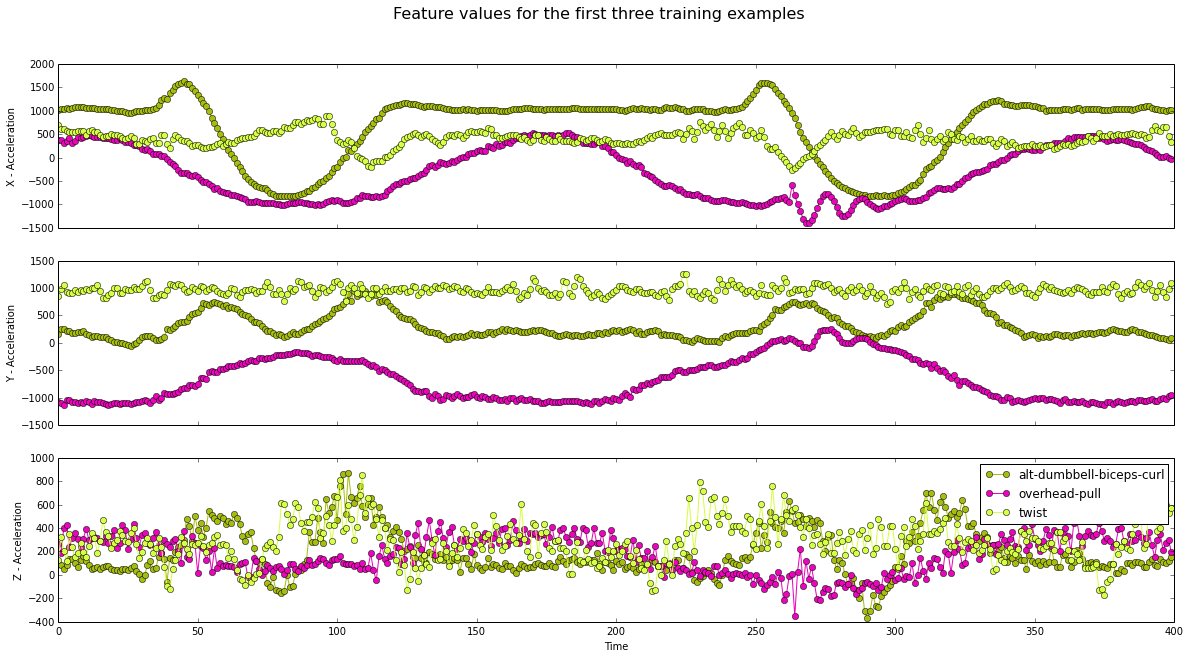

In [5]:
from matplotlib import pyplot, cm
from pylab import *

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

# Retrieve a human readable label given the idx of an example
def label_of_example(i):
    label_id = np.where(dataset.y_train[i] == 1)[0][0]
    return dataset.human_label_for(label_id)

figure(figsize=(20,10))
ax1 = subplot(311)
setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('X - Acceleration')

ax2 = subplot(312, sharex=ax1)
setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel('Y - Acceleration')

ax3 = subplot(313, sharex=ax1)
ax3.set_ylabel('Z - Acceleration')

for i in plot_ids:
    c = np.random.random((3,))

    ax1.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,0:400], '-o', c=c)
    ax2.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,400:800], '-o', c=c)
    ax3.plot(range(0, dataset.feature_count / 3), dataset.X_train[i,800:1200], '-o', c=c)
    
legend(map(label_of_example, plot_ids))
suptitle('Feature values for the first three training examples', fontsize=16)
xlabel('Time')
show()

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [55]:
from neon.backends import gen_backend
from neon.layers import *
from neon.models import MLP
from neon.transforms import RectLin, Tanh, Logistic, CrossEntropy
from neon.experiments import FitPredictErrorExperiment
from neon.params import val_init
from neon.util.persist import serialize

# General settings
max_epochs = 75
epoch_step_size = 1
batch_size = 30 # max(10, min(100, dataset.num_train_examples/10))
random_seed = 42 # Take your lucky number


# Storage director of the model and its snapshots
file_path = expanduser('~/data/workout-cnn/workout-cnn.prm')
#if exists(file_path):
#    remove(file_path)

# Captured errors for the different epochs
train_err = []
test_err = []

print 'Epochs: %d Batch-Size: %d' % (max_epochs, batch_size)

# Generate layers and a MLP model using the given settings
def model_gen(lrate, momentum_coef, num_epochs, batch_size):
    layers = []

    lrule = {
        'lr_params': {
            'learning_rate': lrate,
            'momentum_params': {
                'coef': momentum_coef,
                'type': 'constant'
            }},
        'type': 'gradient_descent_momentum'
    }

    weight_init = val_init.UniformValGen(low=-0.1, high=0.1)

    layers.append(DataLayer(
        nofm=3,
        ofmshape=[400,1],
        is_local=True
    ))
    
    layers.append(ConvLayer(
        name="cv_1",
        nofm=16,
        fshape = [5,1],
        stride = 1,
        lrule_init=lrule,
        weight_init= weight_init,
        activation=RectLin()
    ))

    layers.append(PoolingLayer(
        name="po_1",
        op="max",
        fshape=[2,1],
        stride=2,
    ))

    layers.append(ConvLayer(
        name="cv_2",
        nofm=32,
        fshape = [5,1],
        stride = 1,
        lrule_init=lrule,
        weight_init= weight_init,
        activation=RectLin()
    ))

    layers.append(PoolingLayer(
        name="po_2",
        op="max",
        fshape=[2,1],
        stride=2,
    ))
    
    layers.append(DropOutLayer(
            name="do_1",
            keep = 0.9
        )
    )

    layers.append(FCLayer(
        name="fc_1",
        nout=100,
        lrule_init=lrule,
        weight_init=weight_init,
        activation=RectLin()
    ))
    
    layers.append(DropOutLayer(
            name="do_2",
            keep = 0.9
        )
    )

    layers.append(FCLayer(
        name="fc_2",
        nout=dataset.num_labels,
        lrule_init=lrule,
        weight_init=weight_init,
        activation = Logistic()
    ))

    layers.append(CostLayer(
        name='cost',
        ref_layer=layers[0],
        cost=CrossEntropy()
    ))

    model = MLP(num_epochs=num_epochs, batch_size=batch_size, layers=layers, serialized_path=file_path)
    return model

# Set logging output...
for name in ["neon.util.persist", "neon.datasets.dataset", "neon.models.mlp"]:
    dslogger = logging.getLogger(name)
    dslogger.setLevel(20)

print "Starting training..."
for num_epochs in range(26,max_epochs+1, epoch_step_size):

    if num_epochs > 230:
        lrate = 0.0000003
    elif num_epochs > 60:
        lrate = 0.00001
    elif num_epochs > 40:
        lrate = 0.00003
    else:
        lrate = 0.0001

    # set up the model and experiment
    model = model_gen(lrate = lrate,
                      momentum_coef = 0.9,
                      num_epochs = num_epochs,
                      batch_size = batch_size)

    # Uncomment line below to run on CPU backend
    backend = gen_backend(rng_seed=random_seed)
    # Uncomment line below to run on GPU using cudanet backend
    # backend = gen_backend(rng_seed=0, gpu='cudanet')
    experiment = FitPredictErrorExperiment(model=model,
                                           backend=backend,
                                           dataset=dataset)

    # Run the training, and dump weights
    dest_path = expanduser('~/data/workout-cnn/workout-ep' + str(num_epochs) + '.prm')
    if num_epochs > 0:
        res = experiment.run()
        train_err.append(res['train']['MisclassPercentage_TOP_1'])
        test_err.append(res['test']['MisclassPercentage_TOP_1'])
        # Save the weights at this epoch
        shutil.copy2(file_path, dest_path)
        print "Finished epoch " + str(num_epochs)
    else:
        model.epochs_complete = 0
        serialize(model.get_params(), dest_path)

print "Finished training!"


INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 26, training error: 0.18879


Epochs: 75 Batch-Size: 30
Starting training...
Finished epoch 26

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 27, training error: 0.17689



Finished epoch 27

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 28, training error: 0.16732



Finished epoch 28

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 29, training error: 0.16821



Finished epoch 29

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 30, training error: 0.15454



Finished epoch 30

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 31, training error: 0.14773



Finished epoch 31

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 32, training error: 0.14312



Finished epoch 32

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 33, training error: 0.13829



Finished epoch 33

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 34, training error: 0.13373



Finished epoch 34

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 35, training error: 0.12945



Finished epoch 35

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 36, training error: 0.11935



Finished epoch 36

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 37, training error: 0.11506



Finished epoch 37

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 38, training error: 0.11072



Finished epoch 38

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 39, training error: 0.10636



Finished epoch 39

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 40, training error: 0.10155



Finished epoch 40

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 41, training error: 0.08609



Finished epoch 41

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 42, training error: 0.08162



Finished epoch 42

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 43, training error: 0.07943



Finished epoch 43

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 44, training error: 0.07751



Finished epoch 44

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 45, training error: 0.07616



Finished epoch 45

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 46, training error: 0.07479



Finished epoch 46

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 47, training error: 0.07343



Finished epoch 47

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 48, training error: 0.07225



Finished epoch 48

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 49, training error: 0.07110



Finished epoch 49

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 50, training error: 0.07009



Finished epoch 50

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 51, training error: 0.06924



Finished epoch 51

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 52, training error: 0.06819



Finished epoch 52

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 53, training error: 0.06720



Finished epoch 53

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 54, training error: 0.06627



Finished epoch 54

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 55, training error: 0.06550



Finished epoch 55

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 56, training error: 0.06437



Finished epoch 56

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 57, training error: 0.06377



Finished epoch 57

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 58, training error: 0.06272



Finished epoch 58

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 59, training error: 0.06190



Finished epoch 59

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 60, training error: 0.06101



Finished epoch 60

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 61, training error: 0.05833



Finished epoch 61

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 62, training error: 0.05705



Finished epoch 62

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 63, training error: 0.05655



Finished epoch 63

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 64, training error: 0.05618



Finished epoch 64

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 65, training error: 0.05582



Finished epoch 65

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 66, training error: 0.05549



Finished epoch 66

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 67, training error: 0.05523



Finished epoch 67

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 68, training error: 0.05488



Finished epoch 68

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 69, training error: 0.05459



Finished epoch 69

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 70, training error: 0.05430



Finished epoch 70

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 71, training error: 0.05402



Finished epoch 71

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 72, training error: 0.05376



Finished epoch 72

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 73, training error: 0.05347



Finished epoch 73

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 74, training error: 0.05319



Finished epoch 74

INFO:neon.models.mlp:Layers:
	DataLayer layer: 3 x (400 x 1) nodes
	ConvLayer cv_1: 3 x (400 x 1) inputs, 16 x (396 x 1) nodes, RectLin act_fn
	PoolingLayer po_1: 16 x (396 x 1) inputs, 16 x (198 x 1) nodes, Linear act_fn
	ConvLayer cv_2: 16 x (198 x 1) inputs, 32 x (194 x 1) nodes, RectLin act_fn
	PoolingLayer po_2: 32 x (194 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	DropOutLayer do_1: 32 x (97 x 1) inputs, 32 x (97 x 1) nodes, Linear act_fn
	FCLayer fc_1: 3104 inputs, 100 nodes, RectLin act_fn
	DropOutLayer do_2: 100 inputs, 100 nodes, Linear act_fn
	FCLayer fc_2: 100 inputs, 29 nodes, Logistic act_fn
	CostLayer cost: 29 nodes, CrossEntropy cost_fn

INFO:neon.models.mlp:commencing model fitting
INFO:neon.models.mlp:epoch: 75, training error: 0.05296



Finished epoch 75
Finished training!


To check weather the network is learning something we will plot the weight matrices of the different training epochs.

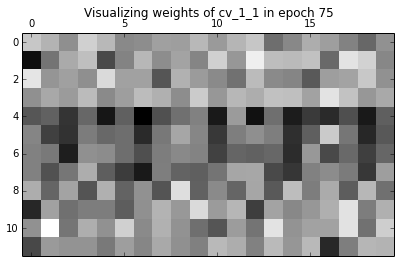

In [56]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
from IPython.html import widgets
from IPython.html.widgets import interact

def closestSqrt(i):
    N = int(math.sqrt(i))
    while True:
        M = int(i / N)
        if N * M == i:
            return N, M
        N -= 1
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = expanduser('~/data/workout-cnn/workout-ep' + str(n) + '.prm')
    params = pkl.load(open(dest_path, 'r'))

    wts = params[layer_name]['weights']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()
    
layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers)))

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=widgets.IntSliderWidget(description='epochs',
                                        min=0, max=max_epochs, value=0, step=epoch_step_size))



Lowest test error: 9.80%
Lowest train error: 1.24%


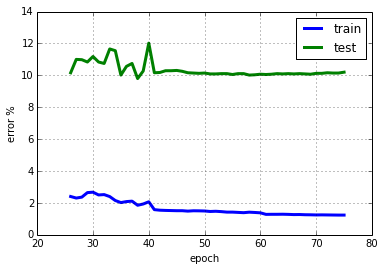

In [58]:
print "Lowest test error: %0.2f%%" % np.min(test_err)
print "Lowest train error: %0.2f%%" % np.min(train_err)

pyplot.plot(range(epoch_step_size*26, max_epochs+1, epoch_step_size), train_err, linewidth=3, label='train')
pyplot.plot(range(epoch_step_size*26, max_epochs+1, epoch_step_size), test_err, linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("error %")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [54]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

# confusion_matrix(y_true, y_pred)
predicted, actual = model.predict_fullset(dataset, "test")

y_pred = np.argmax(predicted.asnumpyarray(), axis = 0) 
y_true = np.argmax(actual.asnumpyarray(), axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt

actual \ predicted,dumbbell-chest-press,dumbbell-chest-fly,barbell-press,lat-pulldown-straight,twist,angle-chest-press,lat-pulldown-angled,cable-cross-overs,dumbbell-press,lateral-raise,side-dips,deltoid-row,leverage-high-row,pulldown-crunch,dumbbell-row,dumbbell-front-rise,triceps-dips,rope-triceps-extension,straight-bar-biceps-curl,cable-deltoid-cross-overs,rope-biceps-curl,straight-bar-triceps-extension,alt-dumbbell-biceps-curl,barbell-biceps-curl,dumbbell-side-rise,overhead-pull,barbell-pullup,rowing,dumbbell-biceps-curl
dumbbell-chest-press,294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dumbbell-chest-fly,0,484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
barbell-press,0,0,249,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
lat-pulldown-straight,0,0,0,153,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
twist,0,0,0,0,467,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,1,0,0,0,0
angle-chest-press,0,0,0,0,0,451,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
lat-pulldown-angled,0,0,0,0,0,0,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cable-cross-overs,0,0,0,0,0,0,0,208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dumbbell-press,137,0,23,0,0,0,0,0,152,0,0,0,0,0,2,39,0,0,0,0,0,0,0,0,56,2,0,0,0
lateral-raise,0,0,0,0,0,0,0,0,0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
